In [3]:
%matplotlib inline

import numpy as np
import scipy as sp
from SimPEG import Mesh, PF, Utils, Maps, DataMisfit, Directives, Inversion, InvProblem, Optimization, Regularization
from GeoToolkit.Mag import Simulator, MathUtils
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from discretize.utils import meshutils
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import shutil
# import pyvista as pv
from skimage import exposure
# pv.set_plot_theme('document')
# pv.rcParams['use_panel'] = False
from fatiando.gravmag import transform

C:\Users\DominiqueFournier\Documents\GIT\Fatiando\Fatiando\fatiando\vis\mpl.py:69: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "matplotlib.pyplot module directly. Some of the fatiando " +


# Data

First import the data and topography

In [4]:
work_dir = r"C:\Users\DominiqueFournier\Dropbox\Projects\Synthetic\Block_Gaussian_topo"
survey = Utils.io_utils.readUBCmagneticsObservations(work_dir + "\\Obs_loc_TMI.obs")[0]


rxLoc = survey.rxLoc
surveyId = survey.std
topo = np.loadtxt(work_dir + "\\Gaussian.topo", skiprows=1)

In [5]:
out = Simulator.dataGriddingWidget(np.c_[survey.rxLoc, survey.dobs], dataColumn=4)
display(out)

interactive(children=(FloatText(value=25.0, description='Grid (m):'), FloatText(value=200.0, description='Dist…

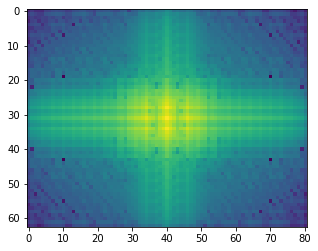

In [6]:
grid = out.result
pwer = np.fft.fftshift(abs(grid.gridFFT)**2.)
plt.figure()
plt.imshow(np.log10(pwer))





C:\Users\DominiqueFournier\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\DominiqueFournier\Anaconda3\Lib\site-packages\matplotlib\mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


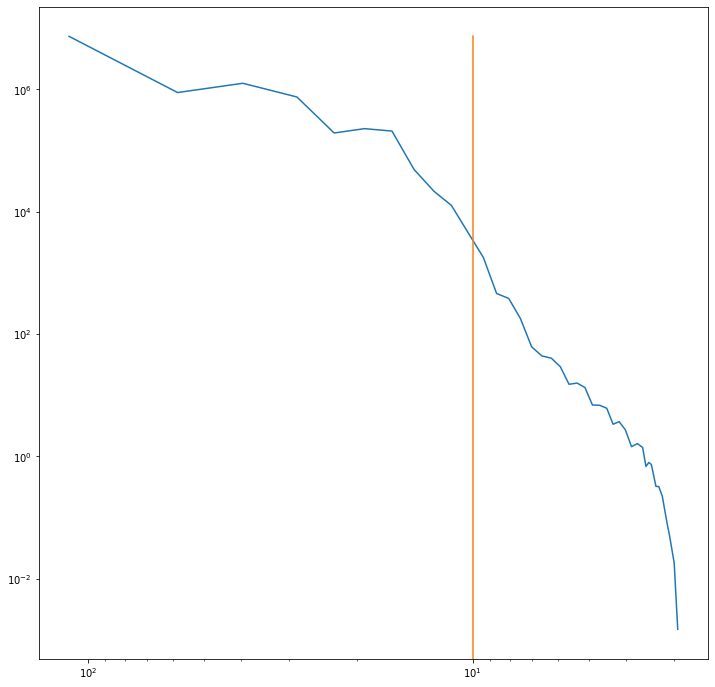

In [7]:


# Compute radial power spectra
axis = np.min(pwer.shape)

# Compute distance of all grid point from the center
X, Y = np.meshgrid(np.arange(-pwer.shape[1]/2, pwer.shape[1]/2), np.arange(-pwer.shape[0]/2, pwer.shape[0]/2))
dist = (X**2 + Y**2)**0.5

Kx_shift = np.fft.fftshift(grid.Kx)
Ky_shift = np.fft.fftshift(grid.Ky)
rad_pwr = []
wave = []
for ii in range(axis):

    ind = (dist>(ii-.5)) * (dist < (ii+.5))
    rad_pwr.append(np.mean(pwer[ind]))
    wave.append((np.mean(Kx_shift[ind]**2 + Ky_shift[ind]**2)**-0.5))

# Cutoff
rad_pwr =  np.hstack(rad_pwr)
wave = np.hstack(wave)
ind = rad_pwr > 1e-4
plt.figure(figsize=(12,12))
axs = plt.subplot()
axs.loglog(wave[ind], rad_pwr[ind])
axs.loglog([grid.dx, grid.dx], [0, rad_pwr[ind].max()])
axs.invert_xaxis()

# Run a forward simulation with single block